In [59]:
import numpy as np
import pandas as pd
import plotly.express as px
from pathlib import Path
from typing import Dict, Optional
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.DataStructs import ConvertToNumpyArray

In [60]:
def show_scatter(data: np.ndarray, color: np.ndarray):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_facecolor('white')
    ff = ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=color)
    plt.colorbar(ff)
    plt.show()
    
def plot_scatter(
    data: np.ndarray,
    color_dict: Dict[str, np.ndarray] = {},
    color: Optional[str] = None,
):

    df_dict = color_dict.copy()

    dim = data.shape[1]
    assert dim in [2, 3]
    for i, name in zip(range(dim), ["x", "y", "z"]):
        df_dict[name] = data[:, i]

    df = pd.DataFrame(df_dict)
    scatter_kwargs = dict(
        x="x",
        y="y",
        color=color,
        width=1000,
        height=1000,
        size_max=7,
        hover_data=list(df_dict.keys()),
    )
    if dim == 2:
        fig = px.scatter(df, **scatter_kwargs)
    else:  # dim == 3
        fig = px.scatter_3d(df, z="z", **scatter_kwargs)
    return fig

In [64]:
def compute_fingerprints(path: str, fp_radius: int = 2, nBits: int = 512) -> np.ndarray:
    fps = []
    mols = []
    text = Path(path).read_text()
    for line in text.rstrip().split("\n"):
        if line[0] == "C": # SMILES string here
            smiles = line.split()[0] # Everything before the empty space is the SMILES string.
            mol = Chem.MolFromSmiles(smiles) # Create molecule object from smile
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, fp_radius, nBits=nBits)
            arr = np.zeros((0,), dtype=np.int8)
            ConvertToNumpyArray(fp, arr)
            fps.append(arr)
            mols.append(mol)
    return np.array(fps), mols

In [65]:
fps, mols = compute_fingerprints("CapsaicinHead.txt", nBits=1024)
fps.shape

(145, 1024)

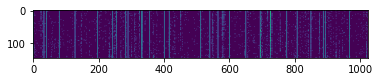

In [22]:
plt.imshow(fps)

In [23]:
row_count = fps.sum(axis=0)
col_count = fps.sum(axis=1)
row_count.shape, col_count.shape

((1024,), (145,))

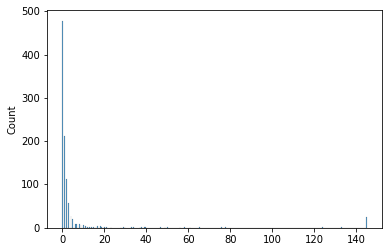

<AxesSubplot:ylabel='Count'>

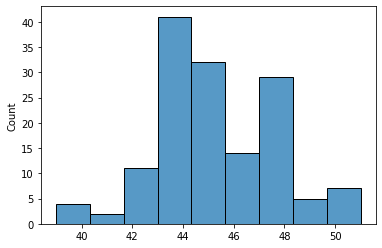

In [24]:
sns.histplot(row_count)
plt.show()
sns.histplot(col_count)

In [25]:
fp_sum = fps.sum(axis=1)
z = (fp_sum - fp_sum.mean()) / fp_sum.std()
z.shape

(145,)

<AxesSubplot:ylabel='Count'>

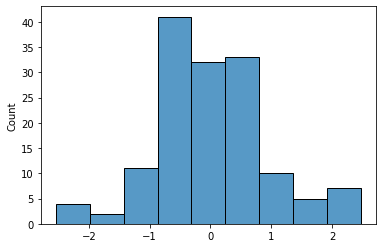

In [26]:
sns.histplot(z)

In [39]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0).fit(fps)

In [40]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
proj = pca.fit_transform(fps)

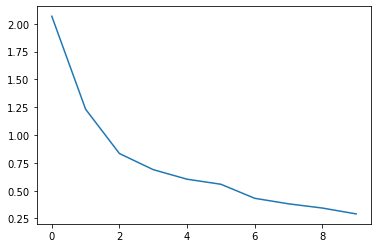

In [41]:
plt.plot(pca.explained_variance_)

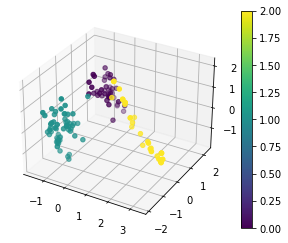

In [43]:
show_scatter(proj[:, :3], color=kmeans.labels_)

In [80]:
# TODO: Run this for interactive plot, clean the code cell before pushing to the repository
#       since the plot takes a lot of storage
#plot_scatter(proj[:, :3], color_dict={"kmeans": kmeans.labels_, "index": np.arange(len(proj))}, color="kmeans")

In [75]:
unique_inds = [127, 59, 21]

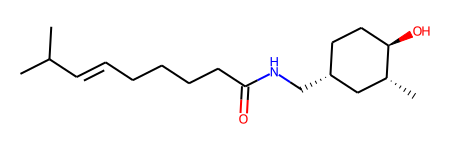

In [76]:
mols[127]

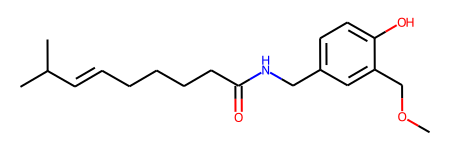

In [77]:
mols[59]

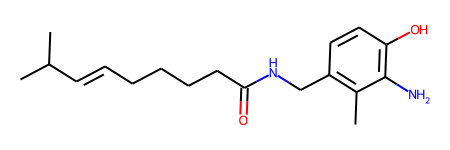

In [78]:
mols[21]

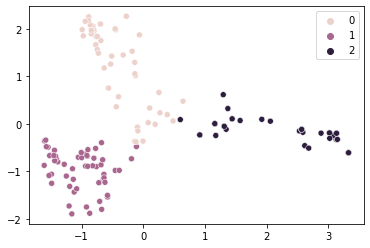

<AxesSubplot:>

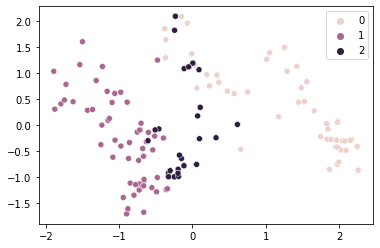

In [42]:
sns.scatterplot(x=proj[:, 0], y=proj[:, 1], hue=kmeans.labels_)
plt.show()
sns.scatterplot(x=proj[:, 1], y=proj[:, 2], hue=kmeans.labels_)

In [44]:
hierarchies = [fps[kmeans.labels_ == cluster, :] for cluster in np.unique(kmeans.labels_)]

In [45]:
for h in hierarchies:
    print(h.shape)

(49, 1024)
(59, 1024)
(37, 1024)


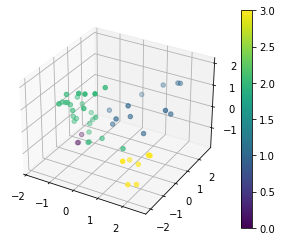

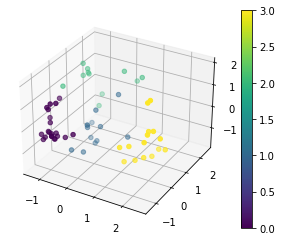

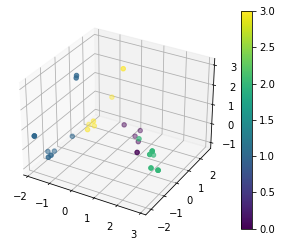

In [46]:
for h in hierarchies:
    pca_h = PCA(n_components=10)
    proj_h = pca.fit_transform(h)
    kmeans_h = KMeans(n_clusters=4, random_state=0).fit(h)
    show_scatter(proj_h[:, :3], color=kmeans_h.labels_)
    plt.show()

In [53]:
def best_first(scores, delta: float = 1e-3):
    sort_inds = np.flip(np.argsort(scores)) # Look at best scores first
    bags = [sort_inds[0]]
    bag_scores = [scores[sort_inds[0]]]
    for ind in sort_inds[1:]:
        if (bag_scores[-1] - scores[ind]) > delta:
            bags.append(ind)
            bag_scores.append(scores[ind])
    return bags, bag_scores

In [51]:
best_first([3,8,2])

([1, 0, 2], [8, 3, 2])

In [52]:
best_first([3,8,2], delta=1)

([1, 0], [8, 3])

In [ ]:
# TODO: Look at score distribution to determine delta
# TODO: Run best_first on the compound scores
# best_first(scores, delta=?)